# LRO LROC NAC (Lunar Reconaissance Orbiter Narrow Angle Camera)

## Imports and Environment

### Knoten

An [Installation of Knoten](https://github.com/DOI-USGS/knoten/tree/main#installing) is requried.
Most imports are included in the [knoten environment](https://github.com/DOI-USGS/knoten/blob/main/environment.yml).

### SPICE Data

`ale.spice_root` must be set to point to the location of your [spice data](https://naif.jpl.nasa.gov/naif/data_archived.html).

The `M114145549LE` image referenced in this notebook has the following times if you wish to download only a subset of the spice data:
```
LRO:PREROLL_TIME                   = 2009-11-29T14:51:21.444
START_TIME                         = 2009-11-29T14:51:21.792
STOP_TIME                          = 2009-11-29T14:51:39.502
```

In [1]:
import os
import urllib.request

import shapely.wkt
import numpy as np
import matplotlib.pyplot as plt

import ale
import knoten.csm as csm

import json
from ale.drivers import AleJsonEncoder

ale.spice_root = '/Volumes/usgs-data/spice-data'

In [2]:
# Download the image from the PDS archives

image_dir = "data"
lrocimage = os.path.join(image_dir, "M114145549LE.IMG")
downloader = urllib.request.URLopener()
if not os.path.isfile(lrocimage):
    downloader.retrieve("http://pds.lroc.asu.edu/data/LRO-L-LROC-2-EDR-V1.0/LROLRC_0001/DATA/MAP/2009333/NAC/M114145549LE.IMG", lrocimage)

In [3]:
# Load ISD from image with ALE
aledict = ale.load(lrocimage)

/usr/local/Caskroom/miniconda/base/envs/knoten/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
# Export the ISD (Istrument Support Data python dictionary) to a JSON ISD file
# (not strictly necessary to use the rest of this notebook)
alelabel = os.path.splitext(lrocimage)[0]+".json"
json.dump(aledict, open(alelabel, "w"), cls=AleJsonEncoder)

In [5]:
# Create CSM Camera Model
camera = csm.create_csm(lrocimage)

Text(0.5, 1.0, 'CSM footprint')

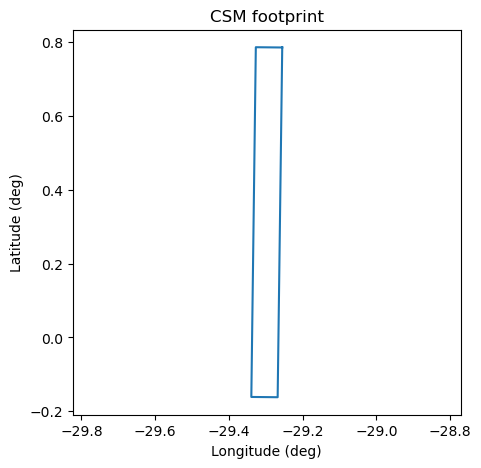

In [6]:
# Get the footprint using the model and plot it

nlines, nsamples = aledict["image_lines"], aledict["image_samples"]

boundary = csm.generate_boundary((nlines, nsamples))

lons, lats, alts = csm.generate_latlon_boundary(camera, boundary, radii=(aledict['radii']['semimajor'], aledict['radii']['semiminor']))

plt.rcParams["figure.figsize"] = [5, 5]
plt.axes().set_aspect('equal','datalim')
plt.plot(lons, lats)
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("CSM footprint")

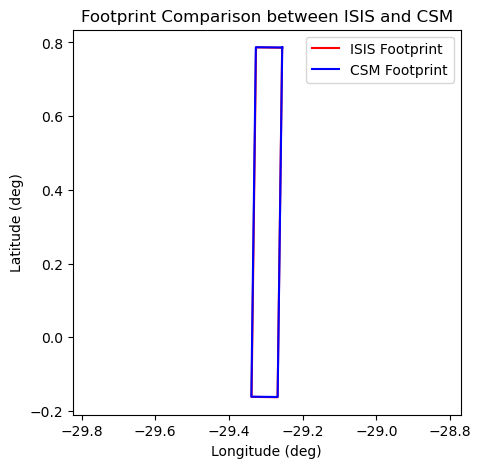

In [7]:
# Plot ALE CSM footprint and ISIS footprint

# Get the ALE CSM footprint
csm_footprint = csm.generate_latlon_footprint(camera, boundary, radii=(aledict['radii']['semimajor'], aledict['radii']['semiminor']))
csm_wkt = csm_footprint.ExportToWkt()
csm_geom = shapely.wkt.loads(csm_wkt)
csm_x, csm_y = csm_geom.geoms[0].exterior.coords.xy

# Get the ISIS footprint

# Footprint from ISIS with the MOLA shape model
# isis_wkt = "MULTIPOLYGON (((330.7463110306657654 0.7854482757922758, 330.6735588190417729 0.7864876048440896, 330.6722203140954548 0.6824921349837477, 330.6708856346948551 0.5784867751929433, 330.6695528942168494 0.4744651462905683, 330.6682212852989551 0.3704277831889312, 330.6668808447899437 0.2663648290874780, 330.6655450736954549 0.1623155226090459, 330.6642026088048283 0.0582676564324625, 330.6628614772421315 -0.0457768626541659, 330.6615245747233303 -0.1497885411680556, 330.6613730584843438 -0.1618174387574025, 330.7338924801659914 -0.1628505723642157, 330.7352604643178324 -0.0588301002076536, 330.7366455716731366 0.0452112834975460, 330.7380675709209186 0.1492562893804125, 330.7393948266972075 0.2533062849556362, 330.7407882559274981 0.3573678783651919, 330.7421071667649812 0.4614106533906304, 330.7434541410839870 0.5654382714301860, 330.7448361647572597 0.6694330923493917, 330.7461634998967952 0.7734253110292049, 330.7463110306657654 0.7854482757922758)))"
# Footprint from ISIS with the ellipsoid shape model
isis_wkt = "MULTIPOLYGON (((330.7441941856566814 0.7854742840476584, 330.6734122512682461 0.7864852431854986, 330.6720775337935265 0.6824887482685454, 330.6707422468992377 0.5784827396620023, 330.6694104474274809 0.4744609137363657, 330.6680745473331626 0.3704235943758753, 330.6667371923622341 0.2663615516122300, 330.6654012477877131 0.1623126491771031, 330.6640604344555641 0.0582651345268398, 330.6627229138327948 -0.0457791387580828, 330.6613854657973093 -0.1497915572533357, 330.6612340759348854 -0.1618205102578877, 330.7318098895715366 -0.1628259665340975, 330.7331709453258668 -0.0588046951220432, 330.7345327017166028 0.0452368646657474, 330.7358957986371024 0.1492823172721610, 330.7372547261704767 0.2533315230515505, 330.7386135675113223 0.3573927197473776, 330.7399719451013880 0.4614347512251011, 330.7413262222544859 0.5654623584288268, 330.7426860862585727 0.6694583537382167, 330.7440433311422794 0.7734511776321239, 330.7441941856566814 0.7854742840476584)))"
isis_geom = shapely.wkt.loads(isis_wkt)
isis_lon, isis_lat = isis_geom.geoms[0].exterior.coords.xy

# Convert ISIS longitude to -180/180
isis_lon_360 = np.asarray(isis_lon)
isis_lon_180 = np.mod(isis_lon_360 - 180.0, 360.0) - 180.0

# Plot the two footprints
plt.rcParams["figure.figsize"] = [5, 5]

plt.title("Footprint Comparison between ISIS and CSM")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.gca().set_aspect('equal','datalim')
isis_plot, = plt.plot(isis_lon_180, isis_lat, 'r')
csm_plot, = plt.plot(csm_x, csm_y, 'b')

isis_plot.set_label("ISIS Footprint")
csm_plot.set_label("CSM Footprint")
plt.legend()

plt.show()